In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, CuDNN 4007)


In [2]:
name = 'MotifSimulation_binary'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, 'N=300000_S=200_M=20_G=20_data.pickle')
train, valid, test = load_data(name, filepath)
shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)

In [4]:
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)

Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.65317 -- accuracy=92.59%  
  valid loss:		0.25194
  valid accuracy:	0.97565+/-0.01132
  valid auc-roc:	0.98123+/-0.02609
  valid auc-pr:		0.82475+/-0.21381
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.18600 -- accuracy=97.98%  
  valid loss:		0.13170
  valid accuracy:	0.98931+/-0.00659
  valid auc-roc:	0.99518+/-0.00843
  valid auc-pr:		0.93516+/-0.12688
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000_S=200_M=20_G=20_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.12755 -- accuracy=98.81%  
  valid loss:		0.10662
  valid accuracy:	0.99240+/-0.00533
  valid auc-roc:	0.99792+/-0.00287
  valid auc-pr:		0.96568+/-0.06510
saving model parameters to: /home/peter/Data/SequenceMotif/N=300000

In [5]:
nnmodel.print_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 4, 200, 1)
layer2: 
shape:(None, 20, 200, 1)
parameters: W
layer3: 
shape:(None, 20, 200, 1)
parameters: b
layer4: 
shape:(None, 20, 200, 1)
parameters: beta, gamma, mean, inv_std
layer5: 
shape:(None, 20, 200, 1)
layer6: 
shape:(None, 20, 50, 1)
layer7: 
shape:(None, 40, 50, 1)
parameters: W
layer8: 
shape:(None, 40, 50, 1)
parameters: b
layer9: 
shape:(None, 40, 50, 1)
parameters: beta, gamma, mean, inv_std
layer10: 
shape:(None, 40, 50, 1)
layer11: 
shape:(None, 40, 25, 1)
layer12: 
shape:(None, 200)
parameters: W
layer13: 
shape:(None, 200)
parameters: b
layer14: 
shape:(None, 200)
parameters: beta, gamma, mean, inv_std
layer15: 
shape:(None, 200)
layer16: 
shape:(None, 200)
layer17: 
shape:(None, 20)
parameters: W
layer18: 
shape:(None, 20)
parameters: b
layer19: 
shape:(None, 20)
-----

In [6]:
network = nnmodel.network
network

{'conv1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f57d9d05c10>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f57d9d762d0>,
 'conv1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f57d9d3e350>,
 'conv1_bias': <lasagne.layers.special.BiasLayer at 0x7f57e4964810>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f57c734e410>,
 'conv2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x7f57c734e450>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f57c734e750>,
 'conv2_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f57c734e5d0>,
 'conv2_bias': <lasagne.layers.special.BiasLayer at 0x7f57c734e490>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f57c734ec90>,
 'dense1': <lasagne.layers.dense.DenseLayer at 0x7f57c734ecd0>,
 'dense1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f57c7358450>,
 'dense1_batch': <lasagne.layers.normalization.BatchNormLayer at 0x7f57c73582d0>,
 'dense1_bias': <lasagne.layers.special.Bias

In [7]:
#X2, labels = reconstruct_layer2(network, train)
map_index = range(10000)
X = train[0][map_index]
y = np.argmax(train[1][map_index], axis=1)

In [8]:
X.shape

(10000, 4, 200, 1)

In [9]:
def get_feature_map(layer, input_var, X, index):
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    return feature_maps(X[index])

output = get_feature_map(network['output'], nnmodel.input_var, X, map_index)

In [10]:
prediction = theano.function([nnmodel.input_var], layers.get_output(network['output'],deterministic=True), allow_input_downcast=True)

In [11]:
index = 18
x = np.expand_dims(X[index],0)

print np.argmax(prediction(x.astype(np.float32)))
print np.argmax(output[index])
print y[index]

0
0
0


[  8.46332729e-01   1.00170576e-03   1.02266436e-03   3.39337741e-03
   4.16899100e-03   3.00469436e-03   8.38111562e-04   5.27830736e-04
   1.59300733e-04   9.67871689e-04   4.77989612e-04   2.82938383e-03
   9.44233965e-04   2.31367606e-03   7.32840213e-04   4.49780404e-04
   1.18369062e-03   9.53735667e-04   1.53963303e-03   5.34863619e-04]


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


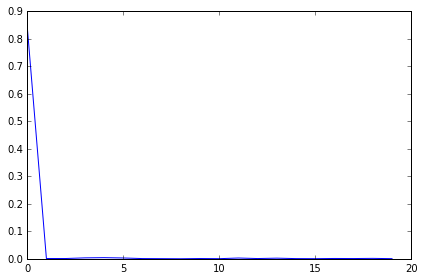

In [12]:
p = prediction(x)
plt.plot(p[0])
print p[0]

In [13]:
index = 18
N = 200
window = 4
x = np.squeeze(X[index])
x.shape

(4, 200)

In [14]:
window = 1

def mutagenesis(x, window=6, N=200):
    p = []
    for i in range(N-window):
        index = range(i, i+window)
        val = np.copy(x)
        val[:, index] = 0
        val = np.expand_dims(val,3)
        p.append(val)
    p = np.array(p)
    return p



In [15]:
p = mutagenesis(x, window=10, N=200)


In [16]:
output2 = get_feature_map(network['output'], nnmodel.input_var, p, range(len(p)))

In [17]:
c = np.argmax(output2,axis=1)
c

array([ 0,  0,  0,  0,  4,  0,  2,  0, 14, 14,  0, 16,  8, 14, 14,  0,  4,
       14,  0, 14,  8,  4, 14, 14, 11,  8, 14, 14,  0,  4,  0,  0,  4,  0,
       12,  0,  0,  0,  0,  0,  1, 13, 10, 19,  1, 12,  2,  3,  1, 12,  3,
       17,  3,  7,  0,  3,  0,  0,  0,  8,  0, 15, 11,  0, 11,  0, 18,  8,
       16, 10, 11,  3, 12,  8,  7, 11, 19,  3,  8, 19,  7,  9,  2, 11,  8,
        1, 19,  9, 16, 11, 13,  0,  0,  9,  0,  0,  0,  0,  0,  1, 16,  0,
       13, 13,  0,  2, 11,  0, 16,  0,  4,  0,  0,  6,  0,  4,  0,  6, 10,
       11,  0, 11,  0, 11,  4,  0,  0, 10,  0,  0,  1,  0, 17,  0,  2, 11,
        0,  6,  0, 13,  0,  0,  3,  0,  0,  0,  3,  4,  4,  4, 17,  4,  4,
        4,  0, 12,  0, 12, 11,  0, 17,  0,  0, 17,  0, 17, 12,  0,  0,  1,
       14,  0,  4,  4, 15, 17,  0, 11,  7,  2,  4,  0,  0,  0,  0, 19, 11,
        0,  8,  0])

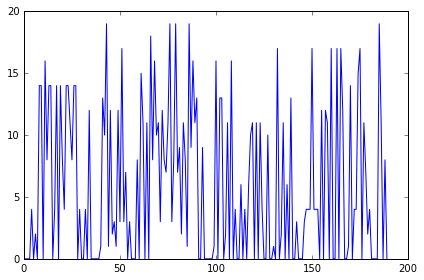

In [18]:
plt.figure()
plt.plot(c)

In [ ]:

def seq_logo(pwm, height=100, width=200, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                correction = 3/2
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
            
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)

    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    nt_width = np.floor(width/num_seq).astype(int)
    logo = np.ones((height, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = height;
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        
        for j in range(num_nt):
            # resized dimensions of image
            if nt_height[j] > 0:
                resize = (nt_height[j],nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)



def plot_conv_filter(plt, pwm, height=200, bp_width=100, norm=0, rna=1, adjust=-1, filepath='.', showbar=0):
    num_seq = pwm.shape[1]
    width = bp_width*num_seq

    logo = seq_logo(pwm, height, width, norm, rna, filepath)
    
    fig, axes = plt.subplots(nrows=2, ncols=1)
    axes[0].imshow(logo, extent=[bp_width*2, width+bp_width, 0, height])
    axes[0].set_axis_off()
    im = axes[1].imshow(pwm, cmap='jet', vmin=0, vmax=1, interpolation='none') 
    axes[1].set_axis_off()
    fig.subplots_adjust(bottom=adjust)
    if showbar == 1:
        cbar_ax = fig.add_axes([.85, 0.05, 0.05, 0.45])
        cb = fig.colorbar(im, cax=cbar_ax, ticks=[0, 0.5, 1])
        cb.ax.tick_params(labelsize=16)
    return fig

def fig_options(plt, options):
    if 'figsize' in options:
        fig = plt.gcf()
        fig.set_size_inches(options['figsize'][0], options['figsize'][1], forward=True)
    if 'ylim' in options:
        plt.ylim(options['ylim'][0],options['ylim'][1])
    if 'yticks' in options:
        plt.yticks(options['yticks'])
    if 'xticks' in options:
        plt.xticks(options['xticks'])
    if 'labelsize' in options:        
        ax = plt.gca()
        ax.tick_params(axis='x', labelsize=options['labelsize'])
        ax.tick_params(axis='y', labelsize=options['labelsize'])
    if 'axis' in options:
        plt.axis(options['axis'])
    if 'xlabel' in options:
        plt.xlabel(options['xlabel'], fontsize=options['fontsize'])
    if 'ylabel' in options:
        plt.ylabel(options['ylabel'], fontsize=options['fontsize'])
    if 'linewidth' in options:
        plt.rc('axes', linewidth=options['linewidth'])
        

def subplot_grid(nrows, ncols):
    grid= mpl.gridspec.GridSpec(nrows, ncols)
    grid.update(wspace=0.2, hspace=0.2, left=0.1, right=0.2, bottom=0.1, top=0.2) 
    return grid


def get_weights(layer, convert_pwm=0):
    W =  np.squeeze(layer.W.get_value())
    W_norm = W
    if convert_pwm == 1:
        for i in range(len(W)):
            #weights = np.exp(W[i])
            MIN = np.min(W[i])
            weights = W[i] - MIN
            Z = np.sum(weights, axis=0)
            weights /= np.tile(Z, (W[i].shape[0],1))
            W_norm[i] = weights
    return W_norm

def plot_conv_weights(W, options):
    num_filters = W.shape[0]
    nrows = np.ceil(np.sqrt(num_filters)).astype(int)
    ncols = nrows
    plt.figure()
    grid = subplot_grid(nrows, ncols)
    for i in range(num_filters):
        plt.subplot(grid[i])
        plt.imshow(W[i], cmap='hot_r', interpolation='nearest')
        fig_options(plt, options)
    return plt

def batch_generator(X, y, batch_size=128, shuffle=True):
    """python generator to get a randomized minibatch"""
    if shuffle:
        indices = np.arange(len(X))
        np.random.shuffle(indices)
    for start_idx in range(0, len(X)-batch_size+1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield X[excerpt].astype('float32'), y[excerpt].astype('int32')


def get_feature_map_all(layer, input_var, X, batch_size=500):
    num_data = len(X)
    feature_maps = theano.function([input_var], layers.get_output(layer), allow_input_downcast=True)
    map_shape = get_output_shape(layer)

    # get feature maps in batches for speed (large batches may be too much memory for GPU)
    batch_size=500
    num_batches = num_data // batch_size
    shape = list(map_shape)
    shape[0] = num_data
    fmaps = np.empty(tuple(shape))
    for i in range(num_batches):
        index = range(i*batch_size, (i+1)*batch_size)    
        fmaps[index] = feature_maps(X[index])

    # get the rest of the feature maps
    excess = num_data-num_batches*batch_size
    if excess:
        index = range(num_data-excess, num_data)  
        fmaps[index] = feature_maps(X[index])
    return fmaps

